In [2]:
import numpy as np

import requests
import re
import time
import os
import pandas as pd
import pickle

from bs4 import BeautifulSoup
from IPython.core.display import display, HTML
from selenium import webdriver
from selenium.webdriver.common.keys import Keys


import diagnostic_plots
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.preprocessing import StandardScaler

% matplotlib inline

/Users/xzhou/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [23]:
# load data from pickle files



filename_berkeley = '/Users/xzhou/github/project_files/project_luther/professor_data_berkely_add_features.pkl' #3986 records
filename_nyu = '/Users/xzhou/github/project_files/project_luther/professor_data_nyu_add_features.pkl' #5607 records
filename_uf = '/Users/xzhou/github/project_files/project_luther/professor_data_uf_add_features.pkl' #5307 records

df_berkeley=pd.read_pickle(filename_berkeley)
df_nyu=pd.read_pickle(filename_nyu)
df_uf=pd.read_pickle(filename_uf)

In [24]:
print(df_berkeley.shape)
print(df_nyu.shape)
print(df_uf.shape)

(3986, 30)
(5607, 30)
(5306, 30)


In [25]:
# define key for each section. This would be used for future references. 
dfs=pd.concat([df_berkeley, df_nyu, df_uf],keys=['berkeley', 'nyu', 'uf'])
dfs.shape

(14899, 30)

In [26]:
# noted records with no professor name
dfs.tail()

Name  Rating  Level of difficulty  Total reviews  \
uf 5301                        0.0                  2.5              0   
   5302                        0.0                  2.5              0   
   5303  Tina D'Allesandro     4.0                  3.0              1   
   5304          Kay Leary     5.0                  3.0              1   
   5305      Lisa Domenico     4.0                  5.0              1   

         Student size  Type_public  Type_private  Region_west  Region_east  \
uf 5301         52367            1             0            0            0   
   5302         52367            1             0            0            0   
   5303         52367            1             0            0            0   
   5304         52367            1             0            0            0   
   5305         52367            1             0            0            0   

         Region_south      ...       Hilarious  Inspirational  Lecture heavy  \
uf 5301             1      ...             0.0            0.0            0.0   
   5302             1      ...             0.0            0.0            0.0   
   5303             1      ...             0.0            0.0            0.0   
   5304             1      ...             0.0            0.0            0.0   
   5305             1      ...             0.0            0.0            0.0   

         Lots of homework  Participation matters  Respected  \
uf 5301               0.0                   0.00        0.0   
   5302               0.0                   0.00        0.0   
   5303               0.0                   0.33        0.0   
   5304               0.0                   0.00        0.0   
   5305               0.0                   0.33        0.0   

         Skip class? you won't pass.  So many papers  Test heavy  Tough grader  
uf 5301                          0.0             0.0         0.0           0.0  
   5302                          0.0             0.0         0.0           0.0  
   5303                          0.0             0.0         0.0           0.0  
   5304                          0.0             0.0         0.0           0.0  
   5305                          0.0             0.0         0.0           0.0  

[5 rows x 30 columns]

In [27]:
dfs[dfs.Name==""].head()

Name  Rating  Level of difficulty  Total reviews  Student size  \
berkeley 244          0.0                  2.5              0         41910   
         274          0.0                  2.5              0         41910   
         376          0.0                  2.5              0         41910   
         416          0.0                  2.5              0         41910   
         478          0.0                  2.5              0         41910   

              Type_public  Type_private  Region_west  Region_east  \
berkeley 244            1             0            1            0   
         274            1             0            1            0   
         376            1             0            1            0   
         416            1             0            1            0   
         478            1             0            1            0   

              Region_south      ...       Hilarious  Inspirational  \
berkeley 244             0      ...             0.0            0.0   
         274             0      ...             0.0            0.0   
         376             0      ...             0.0            0.0   
         416             0      ...             0.0            0.0   
         478             0      ...             0.0            0.0   

              Lecture heavy  Lots of homework  Participation matters  \
berkeley 244            0.0               0.0                    0.0   
         274            0.0               0.0                    0.0   
         376            0.0               0.0                    0.0   
         416            0.0               0.0                    0.0   
         478            0.0               0.0                    0.0   

              Respected  Skip class? you won't pass.  So many papers  \
berkeley 244        0.0                          0.0             0.0   
         274        0.0                          0.0             0.0   
         376        0.0                          0.0             0.0   
         416        0.0                          0.0             0.0   
         478        0.0                          0.0             0.0   

              Test heavy  Tough grader  
berkeley 244         0.0           0.0  
         274         0.0           0.0  
         376         0.0           0.0  
         416         0.0           0.0  
         478         0.0           0.0  

[5 rows x 30 columns]

In [28]:
# remove records that don't have professor names
dfs_smaller=dfs[dfs.Name!=""]
dfs_smaller.shape

(13238, 30)

In [29]:
dfs_smaller=dfs_smaller.fillna(0)

In [30]:
dfs_smaller.columns

Index(['Name', 'Rating', 'Level of difficulty', 'Total reviews',
       'Student size', 'Type_public', 'Type_private', 'Region_west',
       'Region_east', 'Region_south', 'Accessible outside class',
       'Amazing lectures', 'Beware of pop quizzes', 'Caring',
       'Clear grading criteria', 'Extra credit', 'Get ready to read',
       'Gives good feedback', 'Graded by few things', 'Group projects',
       'Hilarious', 'Inspirational', 'Lecture heavy', 'Lots of homework',
       'Participation matters', 'Respected', 'Skip class? you won't pass.',
       'So many papers', 'Test heavy', 'Tough grader'],
      dtype='object')

In [31]:
# Clear out records without tags
dfs_smaller.insert(5,'Total score for Tags', dfs_smaller.sum(axis=1)-dfs_smaller['Rating']-dfs_smaller['Level of difficulty']-dfs_smaller['Total reviews']-dfs_smaller['Student size']-dfs_smaller['Type_public']-dfs_smaller['Type_private']-dfs_smaller['Region_west']-dfs_smaller['Region_east']-dfs_smaller['Region_south'])
dfs_clean=dfs_smaller[dfs_smaller['Total score for Tags']>0.9]
dfs_clean=dfs_clean.drop(['Total score for Tags'], 1)
dfs_clean.head()

Name  Rating  Level of difficulty  Total reviews  \
berkeley 1   Chris Dolder     4.8                  3.9              9   
         2   Bob Calonico     4.7                  1.6             29   
         4    Mary Kelsey     4.6                  1.6             63   
         5    John Searle     3.6                  3.1             47   
         8  William Hanks     4.4                  2.2             25   

            Student size  Type_public  Type_private  Region_west  Region_east  \
berkeley 1         41910            1             0            1            0   
         2         41910            1             0            1            0   
         4         41910            1             0            1            0   
         5         41910            1             0            1            0   
         8         41910            1             0            1            0   

            Region_south      ...       Hilarious  Inspirational  \
berkeley 1             0      ...            0.00           0.50   
         2             0      ...            0.26           0.32   
         4             0      ...            0.00           0.08   
         5             0      ...            0.21           0.07   
         8             0      ...            0.00           0.33   

            Lecture heavy  Lots of homework  Participation matters  Respected  \
berkeley 1           0.00               0.0                   0.00       0.00   
         2           0.00               0.0                   0.00       0.11   
         4           0.04               0.0                   0.08       0.12   
         5           0.00               0.0                   0.00       0.21   
         8           0.00               0.0                   0.00       0.00   

            Skip class? you won't pass.  So many papers  Test heavy  \
berkeley 1                         0.00             0.0         0.0   
         2                         0.00             0.0         0.0   
         4                         0.04             0.0         0.0   
         5                         0.00             0.0         0.0   
         8                         0.33             0.0         0.0   

            Tough grader  
berkeley 1          0.00  
         2          0.00  
         4          0.04  
         5          0.07  
         8          0.00  

[5 rows x 30 columns]

In [32]:
# focus on professor with meaningful number of reviews

dfs_clean=dfs_clean[dfs_clean['Total reviews']>=3]

In [33]:
dfs_clean.shape

(4798, 30)

In [34]:
dfs_clean.columns

Index(['Name', 'Rating', 'Level of difficulty', 'Total reviews',
       'Student size', 'Type_public', 'Type_private', 'Region_west',
       'Region_east', 'Region_south', 'Accessible outside class',
       'Amazing lectures', 'Beware of pop quizzes', 'Caring',
       'Clear grading criteria', 'Extra credit', 'Get ready to read',
       'Gives good feedback', 'Graded by few things', 'Group projects',
       'Hilarious', 'Inspirational', 'Lecture heavy', 'Lots of homework',
       'Participation matters', 'Respected', 'Skip class? you won't pass.',
       'So many papers', 'Test heavy', 'Tough grader'],
      dtype='object')

In [35]:
dfs_clean.describe()

,Rating,Level of difficulty,Total reviews,Student size,Type_public,Type_private,Region_west,Region_east,Region_south,Accessible outside class,...,Hilarious,Inspirational,Lecture heavy,Lots of homework,Participation matters,Respected,Skip class? you won't pass.,So many papers,Test heavy,Tough grader
count,4798.000000,4798.000000,4798.000000,4798.000000,4798.000000,4798.000000,4798.000000,4798.000000,4798.000000,4798.000000,...,4798.000000,4798.000000,4798.000000,4798.000000,4798.000000,4798.000000,4798.000000,4798.000000,4798.000000,4798.000000
mean,3.808629,3.011192,17.503126,52447.240725,0.574198,0.425802,0.264902,0.425802,0.309296,0.036711,...,0.046765,0.063287,0.052209,0.047203,0.062805,0.079454,0.058343,0.012386,0.017614,0.087136
std,0.878436,0.752749,26.916727,6931.836761,0.494516,0.494516,0.441327,0.494516,0.462251,0.076697,...,0.097551,0.106778,0.112295,0.098289,0.109910,0.115346,0.104283,0.050403,0.056999,0.145612
min,1.000000,1.000000,3.000000,41910.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.300000,2.500000,5.000000,41910.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,3.000000,10.000000,52367.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.500000,3.500000,20.000000,59061.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.040000,...,0.050000,0.100000,0.067500,0.050000,0.100000,0.130000,0.090000,0.000000,0.000000,0.140000
max,5.000000,5.000000,507.000000,59061.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,1.000000,1.000000


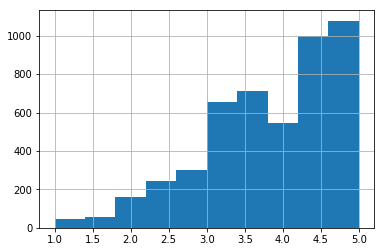

In [36]:
dfs_clean['Rating'].hist()

In [37]:
# Perform transformation of Total reviews and drop unnecessary fields
dfs_clean['Total reviews']=np.log(dfs_clean['Total reviews'])
dfs_clean=dfs_clean.drop('Name', axis=1)
dfs_clean.head()

Rating  Level of difficulty  Total reviews  Student size  \
berkeley 1     4.8                  3.9       2.197225         41910   
         2     4.7                  1.6       3.367296         41910   
         4     4.6                  1.6       4.143135         41910   
         5     3.6                  3.1       3.850148         41910   
         8     4.4                  2.2       3.218876         41910   

            Type_public  Type_private  Region_west  Region_east  Region_south  \
berkeley 1            1             0            1            0             0   
         2            1             0            1            0             0   
         4            1             0            1            0             0   
         5            1             0            1            0             0   
         8            1             0            1            0             0   

            Accessible outside class      ...       Hilarious  Inspirational  \
berkeley 1                      0.00      ...            0.00           0.50   
         2                      0.05      ...            0.26           0.32   
         4                      0.04      ...            0.00           0.08   
         5                      0.00      ...            0.21           0.07   
         8                      0.00      ...            0.00           0.33   

            Lecture heavy  Lots of homework  Participation matters  Respected  \
berkeley 1           0.00               0.0                   0.00       0.00   
         2           0.00               0.0                   0.00       0.11   
         4           0.04               0.0                   0.08       0.12   
         5           0.00               0.0                   0.00       0.21   
         8           0.00               0.0                   0.00       0.00   

            Skip class? you won't pass.  So many papers  Test heavy  \
berkeley 1                         0.00             0.0         0.0   
         2                         0.00             0.0         0.0   
         4                         0.04             0.0         0.0   
         5                         0.00             0.0         0.0   
         8                         0.33             0.0         0.0   

            Tough grader  
berkeley 1          0.00  
         2          0.00  
         4          0.04  
         5          0.07  
         8          0.00  

[5 rows x 29 columns]

In [39]:
#save to pickle for efficiency



filename_berkeley_clean = '/Users/xzhou/github/project_files/project_luther/professor_data_berkeley_cleaned.pkl'
filename_nyu_clean = '/Users/xzhou/github/project_files/project_luther/professor_data_nyu_cleaned.pkl' 
filename_uf_clean = '/Users/xzhou/github/project_files/project_luther/professor_data_uf_cleaned.pkl' 

df_berkeley_clean = dfs_clean.loc['berkeley'].to_pickle(filename_berkeley_clean)
df_nyu_clean=dfs_clean.loc['nyu'].to_pickle(filename_nyu_clean)
df_uf_clean=dfs_clean.loc['uf'].to_pickle(filename_uf_clean)

In [46]:
# Validate that files have been appropriately stored

with open (filename_berkeley_clean, 'rb') as picklefile:
    df_berkeley_clean =pickle.load(picklefile)
print (df_berkeley_clean.shape)
df_berkeley_clean.head(5)


(1271, 29)


,Rating,Level of difficulty,Total reviews,Student size,Type_public,Type_private,Region_west,Region_east,Region_south,Accessible outside class,...,Hilarious,Inspirational,Lecture heavy,Lots of homework,Participation matters,Respected,Skip class? you won't pass.,So many papers,Test heavy,Tough grader
1,4.8,3.9,2.197225,41910,1,0,1,0,0,0.00,...,0.00,0.50,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.00
2,4.7,1.6,3.367296,41910,1,0,1,0,0,0.05,...,0.26,0.32,0.00,0.0,0.00,0.11,0.00,0.0,0.0,0.00
4,4.6,1.6,4.143135,41910,1,0,1,0,0,0.04,...,0.00,0.08,0.04,0.0,0.08,0.12,0.04,0.0,0.0,0.04
5,3.6,3.1,3.850148,41910,1,0,1,0,0,0.00,...,0.21,0.07,0.00,0.0,0.00,0.21,0.00,0.0,0.0,0.07
8,4.4,2.2,3.218876,41910,1,0,1,0,0,0.00,...,0.00,0.33,0.00,0.0,0.00,0.00,0.33,0.0,0.0,0.00


In [45]:
# Validate that files have been appropriately stored

with open (filename_nyu_clean, 'rb') as picklefile:
    df_nyu_clean =pickle.load(picklefile)
print (df_nyu_clean.shape)
df_nyu_clean.head(5)

(2043, 29)


,Rating,Level of difficulty,Total reviews,Student size,Type_public,Type_private,Region_west,Region_east,Region_south,Accessible outside class,...,Hilarious,Inspirational,Lecture heavy,Lots of homework,Participation matters,Respected,Skip class? you won't pass.,So many papers,Test heavy,Tough grader
2,4.3,2.1,3.970292,59061,0,1,0,1,0,0.00,...,0.14,0.31,0.00,0.00,0.07,0.10,0.00,0.00,0.00,0.00
3,3.0,2.9,3.044522,59061,0,1,0,1,0,0.00,...,0.00,0.00,0.09,0.00,0.00,0.00,0.27,0.00,0.00,0.09
4,3.4,2.6,4.406719,59061,0,1,0,1,0,0.06,...,0.15,0.09,0.00,0.03,0.00,0.12,0.00,0.03,0.03,0.03
8,4.7,3.0,4.955827,59061,0,1,0,1,0,0.09,...,0.03,0.11,0.03,0.09,0.00,0.23,0.03,0.00,0.00,0.09
9,3.8,3.2,2.197225,59061,0,1,0,1,0,0.00,...,0.00,0.00,0.00,0.33,0.00,0.00,0.00,0.00,0.00,0.33


In [47]:
# Validate that files have been appropriately stored

with open (filename_uf_clean, 'rb') as picklefile:
    df_uf_clean =pickle.load(picklefile)
print (df_uf_clean.shape)
df_uf_clean.head(5)

(1484, 29)


,Rating,Level of difficulty,Total reviews,Student size,Type_public,Type_private,Region_west,Region_east,Region_south,Accessible outside class,...,Hilarious,Inspirational,Lecture heavy,Lots of homework,Participation matters,Respected,Skip class? you won't pass.,So many papers,Test heavy,Tough grader
1,4.2,1.2,5.384495,52367,1,0,0,0,1,0.04,...,0.11,0.04,0.00,0.00,0.00,0.04,0.00,0.0,0.04,0.00
3,2.5,4.6,3.258097,52367,1,0,0,0,1,0.00,...,0.00,0.00,0.00,0.00,0.25,0.00,0.00,0.0,0.00,0.50
4,4.7,2.4,2.944439,52367,1,0,0,0,1,0.00,...,0.00,0.00,0.00,0.14,0.00,0.00,0.29,0.0,0.00,0.14
11,4.1,2.6,4.454347,52367,1,0,0,0,1,0.00,...,0.12,0.00,0.02,0.09,0.00,0.02,0.05,0.0,0.00,0.02
12,4.2,3.4,2.484907,52367,1,0,0,0,1,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.33
